# 1. Import libraries

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os
from scipy import signal
import lightgbm as lgb

# 2. Load the dataset

In [7]:
for dirname, _, filenames in os.walk('/home/maximka/Desktop/python_jup/experiments/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/maximka/Desktop/python_jup/experiments/experiment_15.csv
/home/maximka/Desktop/python_jup/experiments/experiment_11.csv
/home/maximka/Desktop/python_jup/experiments/experiment_07.csv
/home/maximka/Desktop/python_jup/experiments/experiment_08.csv
/home/maximka/Desktop/python_jup/experiments/experiment_18.csv
/home/maximka/Desktop/python_jup/experiments/experiment_09.csv
/home/maximka/Desktop/python_jup/experiments/experiment_03.csv
/home/maximka/Desktop/python_jup/experiments/experiment_16.csv
/home/maximka/Desktop/python_jup/experiments/experiment_02.csv
/home/maximka/Desktop/python_jup/experiments/experiment_14.csv
/home/maximka/Desktop/python_jup/experiments/train.csv
/home/maximka/Desktop/python_jup/experiments/experiment_12.csv
/home/maximka/Desktop/python_jup/experiments/experiment_17.csv
/home/maximka/Desktop/python_jup/experiments/experiment_04.csv
/home/maximka/Desktop/python_jup/experiments/experiment_13.csv
/home/maximka/Desktop/python_jup/experiments/experiment_06.csv


In [8]:
experiment_result = pd.read_csv("/home/maximka/Desktop/python_jup/experiments/train.csv")
print(f'train.csv : {experiment_result.shape}')
experiment_result.head(3)

train.csv : (18, 7)


,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,wax,6,4.0,unworn,yes,yes
1,2,wax,20,4.0,unworn,yes,yes
2,3,wax,6,3.0,unworn,yes,yes


In [9]:
experiment_tmp = pd.read_csv("/home/maximka/Desktop/python_jup/experiments/experiment_01.csv")
print(f'experiment_XX.csv : {experiment_tmp.shape}')
print(experiment_tmp.columns)
experiment_tmp.head(3)

experiment_XX.csv : (1055, 48)
Index(['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
       'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback',
       'S1_DCBusVoltage', 'S1

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep


# 3. Pre-processing

>NaN in passed_visual_inspection in experiment result means machining_finalized is no, which means machining process was not finished correctly and did not proceed to visual inspection process. So, we need to fill NaN with no.

In [11]:
experiment_result['passed_visual_inspection'] = experiment_result['passed_visual_inspection'].fillna('no')

>adding each experiment settings and result to experiment time series data to make one total dataframe.

In [13]:
frames = []
for i in range(1,19):
    #load files
    exp_num = '0' + str(i) if i < 10 else str(i)
    frame = pd.read_csv(f"/home/maximka/Desktop/python_jup/experiments/experiment_{exp_num}.csv")

    #load each experiment result row
    exp_result_row = experiment_result[experiment_result['No'] == i]
    frame['exp_num'] = i

    #add experiment settings to features
    frame['material'] = exp_result_row.iloc[0]['material']
    frame['feedrate'] = exp_result_row.iloc[0]['feedrate']
    frame['clamp_pressure'] = exp_result_row.iloc[0]['clamp_pressure']
    
    #add experiment result to features
    frame['tool_condition'] = exp_result_row.iloc[0]['tool_condition']
    frame['machining_finalized'] = exp_result_row.iloc[0]['machining_finalized']
    frame['passed_visual_inspection'] = exp_result_row.iloc[0]['passed_visual_inspection']

    frames.append(frame)

df = pd.concat(frames, ignore_index = True)
df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,exp_num,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,0.0,50.0,Starting,1,wax,6,4.0,unworn,yes,yes
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,4.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes


In [14]:
df.shape

(25286, 55)

In [15]:
df['Machining_Process'].value_counts().sort_index()

End              2585
Layer 1 Down     2655
Layer 1 Up       4085
Layer 2 Down     2528
Layer 2 Up       3104
Layer 3 Down     2354
Layer 3 Up       2794
Prep             1795
Repositioning    3377
Starting            1
end                 8
Name: Machining_Process, dtype: int64

In [16]:
print(f"Count of Starting label in Machining_Process column is 1 only in experimet_{df[df['Machining_Process']=='Starting'].exp_num.value_counts().index[0]}")
print(f"Count of end label in Machining_Process column is 8 only in experimet_{df[df['Machining_Process']=='end'].exp_num.value_counts().index[0]}")

Count of Starting label in Machining_Process column is 1 only in experimet_1
Count of end label in Machining_Process column is 8 only in experimet_1


In [17]:
df.replace({'Machining_Process': {'Starting':'Prep','end':'End'}}, inplace=True)

# 4. Modeling


In [20]:
for ax in ['X','Y','Z','S']:
    df[f'{ax}1_Position_Diff'] = abs(df[f'{ax}1_CommandPosition']-df[f'{ax}1_ActualPosition'])
    df[f'{ax}1_Velocity_Diff'] = abs(df[f'{ax}1_CommandVelocity']-df[f'{ax}1_ActualVelocity'])
    df[f'{ax}1_Acceleration_Diff'] = abs(df[f'{ax}1_CommandAcceleration']-df[f'{ax}1_ActualAcceleration'])

In [21]:
for col in ['ActualPosition','ActualVelocity','ActualAcceleration','CurrentFeedback','DCBusVoltage','OutputCurrent','OutputVoltage','OutputPower']:
    dt = 0.1
    for i in range(1,19):
        for ax in ['X','Y','Z','S']:
            try:
                f = df[df['exp_num']==i].reset_index()[f'{ax}1_{col}']
            except:
                continue
                
            N = len(f)
            t = np.arange(0, N*dt, dt)
            freq = np.linspace(0, 1.0/dt, N)
            F = np.fft.fft(f)
            F_abs = np.abs(F) / (N/2) 
            F_abs[0] = F_abs[0] / 2
            maximal_idx = signal.argrelmax(F_abs, order=1)[0]

            high_amp = np.max(F_abs[maximal_idx]) if len(maximal_idx) > 0 else 0
            high_freq = freq[maximal_idx][np.argmax(F_abs[maximal_idx])] if len(maximal_idx) > 0 else 0

            df.loc[df['exp_num']==i,f'{ax}1_{col}_High_Amp'] = high_amp
            df.loc[df['exp_num']==i,f'{ax}1_{col}_High_Freq'] = high_freq
            df.loc[df['exp_num']==i,f'{ax}1_{col}_High_Amp_Freq'] = high_amp * high_freq

>label encoding & drop unnecessary columns

In [22]:
feature_df = df.copy()
feature_df['Machining_Process'] = LabelEncoder().fit_transform(feature_df['Machining_Process']).astype(np.int8)
feature_df['tool_condition'] = LabelEncoder().fit_transform(feature_df['tool_condition']).astype(np.int8)
feature_df['machining_finalized'] = LabelEncoder().fit_transform(feature_df['machining_finalized']).astype(np.int8)
feature_df['passed_visual_inspection'] = LabelEncoder().fit_transform(feature_df['passed_visual_inspection']).astype(np.int8)
feature_df.drop(['material','exp_num'], axis=1, inplace=True)
feature_df.head(3)

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputVoltage_High_Amp_Freq,X1_OutputPower_High_Amp,X1_OutputPower_High_Freq,X1_OutputPower_High_Amp_Freq,Y1_OutputPower_High_Amp,Y1_OutputPower_High_Freq,Y1_OutputPower_High_Amp_Freq,S1_OutputPower_High_Amp,S1_OutputPower_High_Freq,S1_OutputPower_High_Amp_Freq
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,0.222398,0.000492,0.199241,0.000098,0.000725,9.867173,0.00715,0.011293,3.358634,0.03793
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,0.222398,0.000492,0.199241,0.000098,0.000725,9.867173,0.00715,0.011293,3.358634,0.03793
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,0.222398,0.000492,0.199241,0.000098,0.000725,9.867173,0.00715,0.011293,3.358634,0.03793


In [23]:
feature_df.shape,

((25286, 158),)

In [24]:
feature_df['X1_DCBusVoltage'].value_counts()

2.790000e-19    770
2.780000e-19    709
1.010000e-01    259
1.020000e-01    251
1.040000e-01    235
               ... 
3.270000e-01      1
2.830000e-01      1
2.500000e-01      1
3.650000e-01      1
3.010000e-01      1
Name: X1_DCBusVoltage, Length: 1042, dtype: int64

## Case1 : Tool Condition

In [33]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler

In [34]:
feature_df['X1_DCBusVoltage_High_Freq'] = feature_df['X1_DCBusVoltage_High_Freq'].astype(float)

In [35]:
feature_df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputVoltage_High_Amp_Freq,X1_OutputPower_High_Amp,X1_OutputPower_High_Freq,X1_OutputPower_High_Amp_Freq,Y1_OutputPower_High_Amp,Y1_OutputPower_High_Freq,Y1_OutputPower_High_Amp_Freq,S1_OutputPower_High_Amp,S1_OutputPower_High_Freq,S1_OutputPower_High_Amp_Freq
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,0.222398,0.000492,0.199241,0.000098,0.000725,9.867173,0.00715,0.011293,3.358634,0.03793
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,0.222398,0.000492,0.199241,0.000098,0.000725,9.867173,0.00715,0.011293,3.358634,0.03793
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,0.222398,0.000492,0.199241,0.000098,0.000725,9.867173,0.00715,0.011293,3.358634,0.03793
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,0.222398,0.000492,0.199241,0.000098,0.000725,9.867173,0.00715,0.011293,3.358634,0.03793
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,0.222398,0.000492,0.199241,0.000098,0.000725,9.867173,0.00715,0.011293,3.358634,0.03793


<AxesSubplot:>

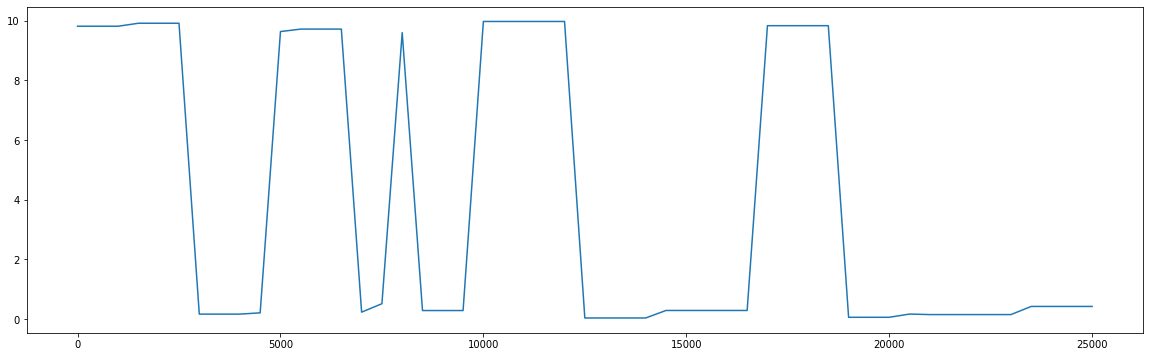

In [36]:
feature_df['X1_DCBusVoltage_High_Freq'][::500].plot(figsize=(20,6))


In [37]:
import math

In [38]:
d = feature_df.filter(['X1_DCBusVoltage_High_Freq'])

In [39]:
dataset = d.values
len(dataset)

25286

In [40]:
training_data_size = math.ceil(len(dataset)*.7)
training_data_size

17701

In [41]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.983946  ],
       [0.983946  ],
       [0.983946  ],
       ...,
       [0.03892291],
       [0.03892291],
       [0.03892291]])

In [55]:
train_data = scaled_data[0:training_data_size,:]
x_train_1=[]
y_train_1=[]
for i in range(60,len(train_data)):
    x_train_1.append(train_data[i-60:i,0])
    y_train_1.append(train_data[i,0])
    if i<=61:
        print(x_train_1)
        print(y_train_1)

[array([0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946])]
[0.9839460016050515]
[array([0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 0.983946, 0.983946, 0.983946,
       0.983946, 0.983946, 0.983946, 

In [61]:
x_train_1, y_train_1 = np.array(x_train_1), np.array(y_train_1)
x_train_1 = np.reshape(x_train_1,(x_train_1.shape[0],x_train_1.shape[1],1))
x_train_1.shape

(17641, 60, 1)

In [63]:
x_train_1

array([[[0.983946  ],
        [0.983946  ],
        [0.983946  ],
        ...,
        [0.983946  ],
        [0.983946  ],
        [0.983946  ]],

       [[0.983946  ],
        [0.983946  ],
        [0.983946  ],
        ...,
        [0.983946  ],
        [0.983946  ],
        [0.983946  ]],

       [[0.983946  ],
        [0.983946  ],
        [0.983946  ],
        ...,
        [0.983946  ],
        [0.983946  ],
        [0.983946  ]],

       ...,

       [[0.98577327],
        [0.98577327],
        [0.98577327],
        ...,
        [0.98577327],
        [0.98577327],
        [0.98577327]],

       [[0.98577327],
        [0.98577327],
        [0.98577327],
        ...,
        [0.98577327],
        [0.98577327],
        [0.98577327]],

       [[0.98577327],
        [0.98577327],
        [0.98577327],
        ...,
        [0.98577327],
        [0.98577327],
        [0.98577327]]])

In [65]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train_1.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [66]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [67]:
model.fit(x_train_1, y_train_1, batch_size=1,epochs=1)

17641/17641 [==============================] - 826s 47ms/step - loss: 0.0013


In [68]:
test_data = scaled_data[training_data_size - 60:, :]
x_test_1 = []
y_test_1 = dataset[training_data_size:, :]
for i in range(60, len(test_data)):
    x_test_1.append(test_data[i-60:i, 0])
    

In [71]:
x_test_2 = np.array(x_test_1)

In [72]:
x_test_2 = np.reshape(x_test_2, (x_test_2.shape[0], x_test_2.shape[1],1))

In [74]:
predictions = model.predict(x_test_2)
predictions = scaler.inverse_transform(predictions)

In [75]:
rmse = np.sqrt(np.mean(predictions - y_test_1)**2)
rmse

0.012129501307454466

<ipython-input-76-96314cf21252>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


<function matplotlib.pyplot.show(close=None, block=None)>

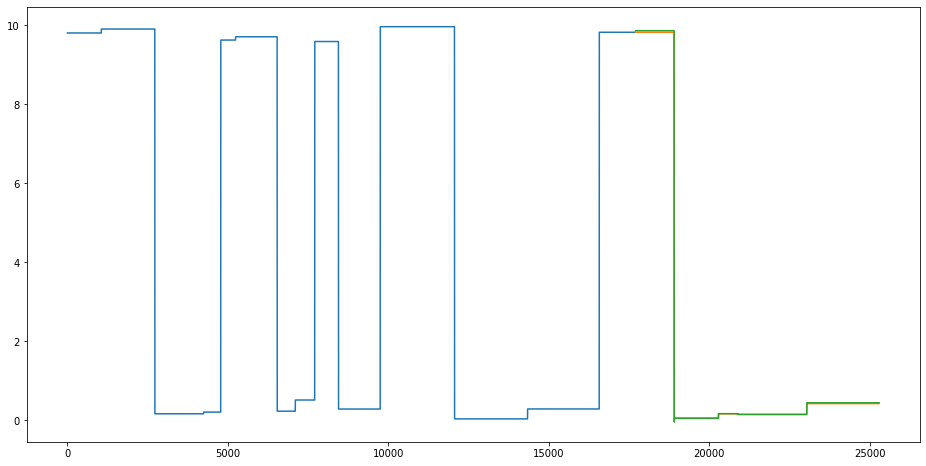

In [76]:
train = d[:training_data_size]
valid = d[training_data_size:]
valid['predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['X1_DCBusVoltage_High_Freq'])
plt.plot(valid[['X1_DCBusVoltage_High_Freq','predictions']])
plt.show

In [77]:
valid

,X1_DCBusVoltage_High_Freq,predictions
17701,9.828400,9.868627
17702,9.828400,9.868627
17703,9.828400,9.868627
17704,9.828400,9.868627
17705,9.828400,9.868627
...,...,...
25281,0.421847,0.442698
25282,0.421847,0.442698
25283,0.421847,0.442698
25284,0.421847,0.442698
